In [241]:
import cv2 as cv
import numpy as np
from IPython.display import Image, display
import math
from numpy.linalg import norm
import random
import PIL.Image
import io
import json
import pickle
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
from skspatial.objects import Line
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans

calib_mtx = np.array([[656.21492489,   0.        , 433.36419249],
       [  0.        , 634.36590008, 549.00237266],
       [  0.        ,   0.        ,   1.        ]])

calib_dist = np.array([[  3.6314616 ],
       [-20.14867951],
       [ -0.24932133],
       [ -0.21291317],
       [ 30.16925059]])

from scipy.spatial.transform import Rotation as R
import tqdm

In [243]:
def check_intersection(line1, line2):
    line1_sk = Line.from_points(line1[:2], line1[2:])
    line2_sk = Line.from_points(line2[:2], line2[2:])

    try:
        intersect = line1_sk.intersect_line(line2_sk)
    except ValueError:
        return False, None

    return True, intersect

def cos_similarity(line1, line2):
    A = np.array(line1[:2] - line1[2:])
    B = np.array(line2[:2] - line2[2:])
    return np.dot(A,B)/(norm(A) * norm(B))

def line_angle(line):
    return np.arctan2(line[0] - line[2], line[1] - line[3])

def find_grid_points(frame):
    # Canny edge and hough lines
    edges = cv.Canny(frame,50,250)
    edges = cv.dilate(edges.astype('uint8'), np.ones((2,2), np.uint8), iterations=3)

    lines = cv.HoughLinesP(edges, 2, math.radians(0.1), 400, minLineLength=200, maxLineGap=20)
        
    if lines is None:
        return [], frame
        
    X = [line_angle(l[0]) for l in lines]
    if len(X) < 2:
        return [], frame
    line_cluster = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(np.array([X]).reshape(-1,1))

        # Now we have two cateogires, vertical and horizontal lines, look for intersections between vert and horiz
    lines_a, lines_b = [], []
    for l in lines:
        angle = line_angle(l[0])
        category = line_cluster.predict(np.array([angle]).reshape(-1,1))[0]
        x1,y1,x2,y2 = l[0]
        if category == 0:
            lines_a.append(l)
            cv.line(frame,(x1,y1),(x2,y2),(0,255,0),2)
        elif category == 1:
            lines_b.append(l)
            cv.line(frame,(x1,y1),(x2,y2),(255,0,0),2)
    
    # Find points intersecting with line
    points = []
    for i,l1 in enumerate(lines_a):
        for j,l2 in enumerate(lines_b):
            similarity = cos_similarity(l1[0], l2[0])
            #print(l1[0][2])
            has_intersect, point = check_intersection(l1[0].astype(float), l2[0].astype(float))
            if has_intersect:
                oob = np.any(point > frame.shape[:2]) | np.any(point < 0)
                if not oob:
                    points.append(point)

    for point in points:
        cv.circle(frame, center=(point[0].astype('uint32'), point[1].astype('uint32')), radius=2, color=(255,0,0))

    if len(points) == 0:
        return [], frame
    bandwidth = estimate_bandwidth(points, quantile=0.025, n_samples=50000)
    if bandwidth == 0:
        return [], frame
    clustering = MeanShift(bandwidth=bandwidth).fit(points)
    centers = clustering.cluster_centers_
    cluster_frame = frame.copy()
    for i, point in enumerate(centers):
        location = (point[0].astype('uint32'), point[1].astype('uint32'))
        cv.circle(frame, center=location, thickness=-1, radius=6, color=(0,100,255))
        frame = cv.putText(frame, f"{i}", location, cv.FONT_HERSHEY_SIMPLEX, 0.75, (255,20,255), 2, cv.LINE_AA)

    return centers, frame

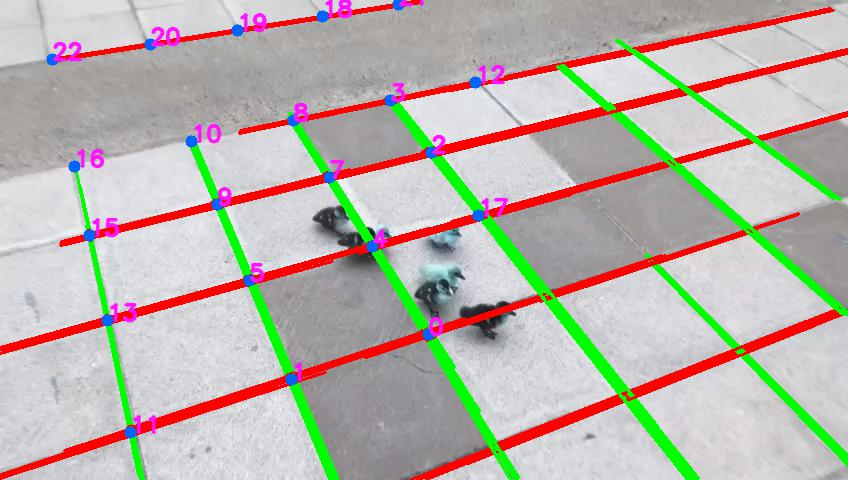

In [244]:
cap = cv.VideoCapture("patitos.mp4")
ret, frame = cap.read()
center, frame = find_grid_points(frame)
showarray(frame)

In [245]:
# Returns which centers in frame 1correspond to which centers in frame 2
def find_matching_features(centers_1, centers_2):
    selected_centers = []
    # For each point in centers, look for closest point in the other list
    for p in centers_1:
        min_dist = 99999
        min_point = -1
        for i,p_2 in enumerate(centers_2):
            dist = np.hypot(p[0] - p_2[0], p[1] - p_2[1])
            if dist < min_dist and i not in selected_centers:
                min_dist = dist
                min_point = i
        if min_dist < 500:
            selected_centers.append(min_point)

    return selected_centers

def recover_pose_from_points(centers_1, centers_2, matches):
    # Build centers_1 matrix, only add centers if has valid match
    p1, p2 = [], []
    for i, match in enumerate(matches):
        if match != -1:
            p1.append(centers_1[i])
            p2.append(centers_2[match])
    p1 = np.array(p1)
    p2 = np.array(p2)
    E, mask = cv.findEssentialMat(p1, p2, calib_mtx)
    good, R, t, _ = cv.recoverPose(E, p1, p2)
    return R, t

In [37]:
ret, frame1 = cap.read()
ret, frame2 = cap.read()

In [103]:
centers_1, annotated_1 = find_grid_points(frame1)
centers_2, annotated_2 = find_grid_points(frame2)
matches = find_matching_features(centers_1, centers_2)

In [106]:
recover_pose_from_points(centers_1, centers_2, matches)

(array([[-0.29902104, -0.89911188, -0.3196627 ],
        [ 0.67760654,  0.03580251, -0.73455263],
        [ 0.67188972, -0.43625223,  0.59853838]]),
 array([[ 0.40255682],
        [ 0.61920543],
        [-0.67419036]]))

In [252]:
cap = cv.VideoCapture("patitos.mp4")
camera_rot = R.from_euler('xyz',[0,0,0])
t = np.zeros((3,1))
camera_translation = []
camera_rot = []
ret, last_frame = cap.read()
for _ in tqdm.tqdm(range(2000)):
    ret, frame1_raw = cap.read()
    if not ret:
        break
    frame1 = cv.undistort(frame1_raw, calib_mtx, calib_dist, None)
    frame2 = cv.undistort(last_frame, calib_mtx, calib_dist, None)
    centers_1, annotated_1 = find_grid_points(frame1)
    centers_2, annotated_2 = find_grid_points(frame2)
    matches = find_matching_features(centers_1, centers_2)
    if len(centers_1) == 0 or len(centers_2) == 0:
        continue
    rot, T = recover_pose_from_points(centers_1, centers_2, matches)
    r = R.from_matrix(rot)
    camera_rot.append(rot.copy())
    t += T
    camera_translation.append(t.copy())
    last_frame = frame1_raw.copy()

100%|█████████████████████████████████████████████████████████████████████████████████| 2000/2000 [15:23<00:00,  2.17it/s]


Text(0.5, 0, 'Z')

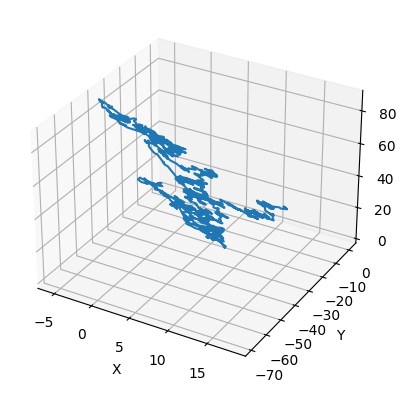

In [255]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(np.array(camera_translation)[:,0,:], 
           np.array(camera_translation)[:,1,:],
            np.array(camera_translation)[:,2,:])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

In [ ]:
# Create 3d plot video
from PIL import Image
translation = np.array(camera_translation)
image_size = (840*2,480*2)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
cap = cv.VideoCapture("patitos.mp4")
for i in tqdm.tqdm(range(2,2000)):
    pos = translation[:i,:,:]
    x,y,z = pos[:,0,:], pos[:,1,:], pos[:,2,:]
    #ax.set_xlim(-6, 25)
    #ax.set_ylim(-6, 50)
    #ax.set_zlim(-100, 100)
    ax.plot(x,y,z)
    plot_filename = 'plots/{:04d}.png'.format(i)
    plt.savefig(plot_filename)
    plt.cla()

    ret, frame = cap.read()
    ret, frame = cap.read()
    frame_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    plt_im = Image.open(plot_filename).resize(image_size)
    vid_im = Image.fromarray(frame_rgb).resize(image_size)

    combined_image = Image.new('RGB', (image_size[0] * 2, image_size[1]))
    combined_image.paste(plt_im, (0,0))
    combined_image.paste(vid_im, (image_size[0],0))
    combined_image.save('out/{:04d}.png'.format(i))

 40%|████████████████████████████████▍                                                 | 790/1998 [07:19<11:09,  1.80it/s]

In [232]:
min(pos[:,2,:])

array([-94.30015251])

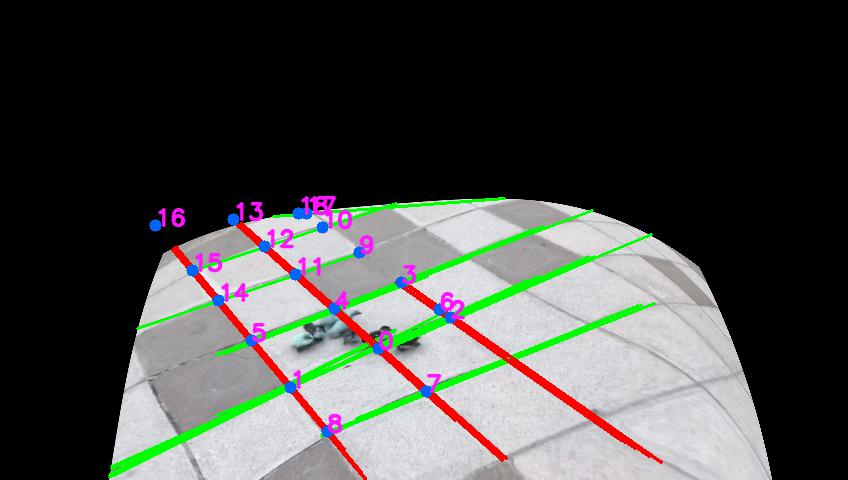

In [148]:
ret, frame1 = cap.read()
frame1 = cv.undistort(frame1, calib_mtx, calib_dist, None)
centers_1, annotated_1 = find_grid_points(frame1)
showarray(annotated_1)